In [1]:
using Revise
includet("../IFMAB3.jl")
includet("../SWQG.jl")
using .SWQG
using FourierFlows
using FourierFlows: radialspectrum
using Printf
using LinearAlgebra: mul!, ldiv!
using CairoMakie
using AbstractFFTs

In [2]:
function set_shafer_initial_condition_QG!(prob, Kg, ag)
    grid = prob.grid
    dev = typeof(grid.device)
    T = typeof(grid.Lx)

    @devzeros dev Complex{T} (grid.nkr, grid.nl) ψh
    @devzeros dev T (grid.nx, grid.ny) ψ u
    
    geo_filter  = Kg[1]^2 .<= grid.Krsq .<= Kg[2]^2
    phase = device_array(grid.device)(2π*rand(grid.nkr, grid.nl))
    shift = exp.(1im * phase)
    ψh[geo_filter] += 0.5*shift[geo_filter]

    ldiv!(ψ, grid.rfftplan, deepcopy(ψh))
    ldiv!(u, grid.rfftplan, -grid.l .* ψh)
    
    ψh *= ag / maximum(abs.(u))
    SWQG.set_solution!(prob, ψh)
end

set_shafer_initial_condition_QG! (generic function with 1 method)

In [3]:
dev = GPU()
Lx=2π
nx=512
dx=Lx/nx
kmax = nx/2 - 1
nν=4
nsteps = 90000
nsubs = 300
#ν = 1.0e-16 * (nx)
cfltune = 0.1
umax = 0.3
νtune = 0.2/cfltune# 250000
dt = cfltune / umax * dx
ν = νtune * 2π / nx / (kmax^(2*nν)) / dt
#umax = 4
#ν = 9e-19
#dt = 0.0007


prob = SWQG.Problem(dev; Lx, nx, dt, f=3.0, T=Float32, nν, ν, aliased_fraction=1/3, make_filter=false)
grid, clock, vars, params = prob.grid, prob.clock, prob.vars, prob.params

set_shafer_initial_condition_QG!(prob, (10, 13), 0.3)
#ζ_diss = parsevalsum2(grid.Krsq.^(nν/2) .* prob.vars.ζh, grid)
#println(sqrt(kmax^(2*nν) * ζ_diss^(-3)))
#set_shafer_initial_condition_QG!(qg_prob, (10, 13), maximum(abs.(prob.vars.η))*params.Cg2/params.f, params.f, params.Cg2)
#set_wave_band_ic!(prob)
#set_channel_initial_condition!(prob, 0.1)

ν = 3.3560606979789085e-19
dt = 0.00409061543436171
|u| = 0.33653527
|ψ| = 0.13269007
cfl = 0.11217842499415082
|L| = 99.05343


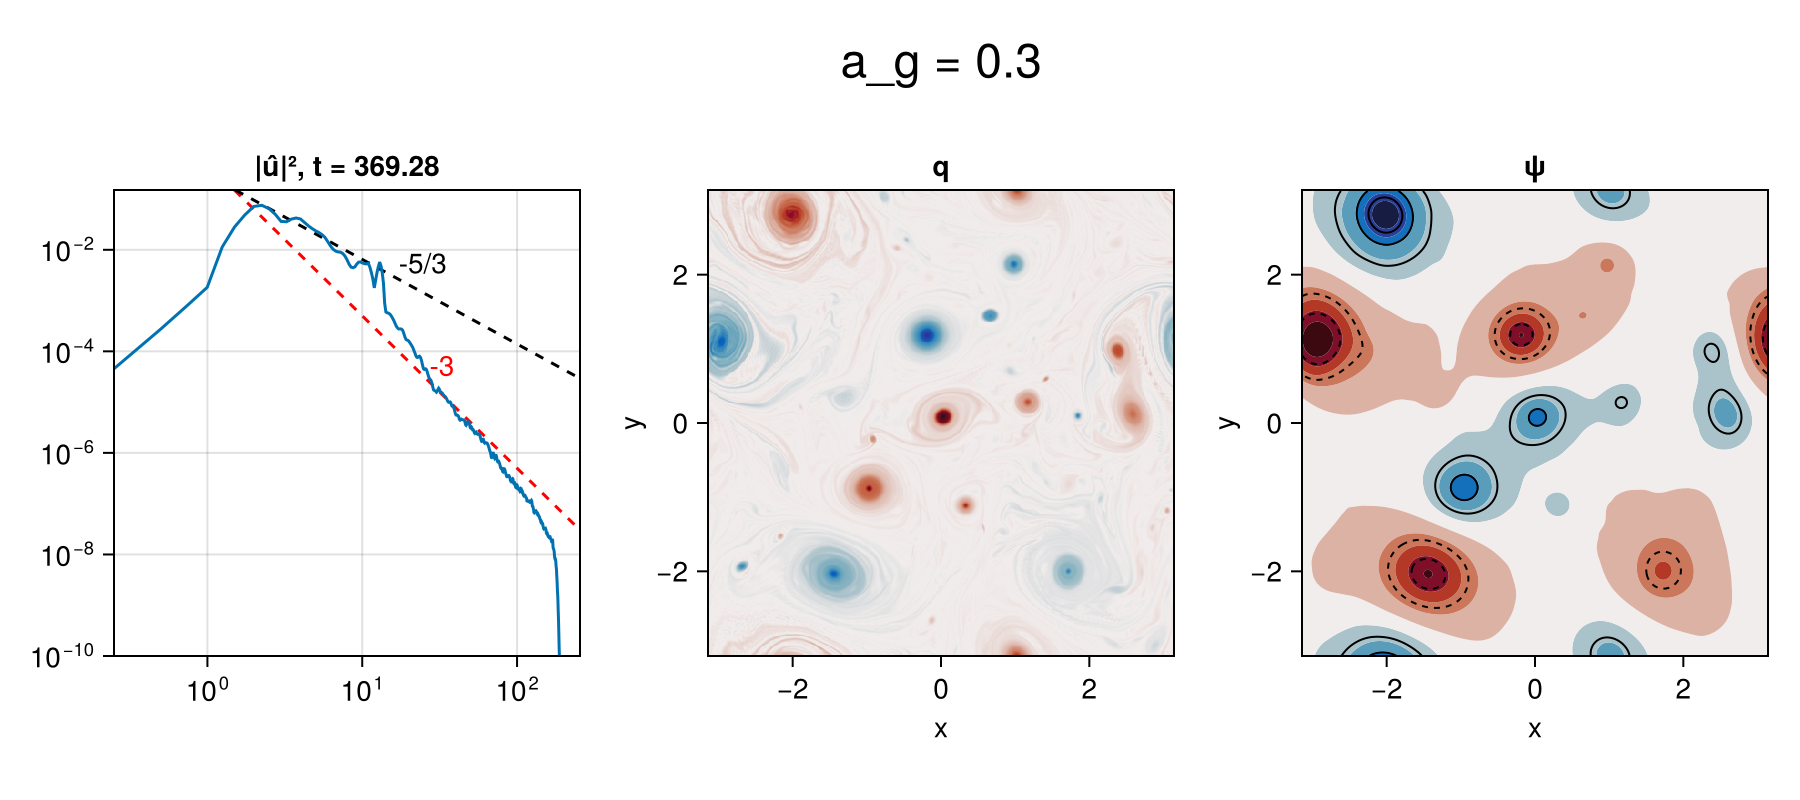

In [13]:
Lx, Ly = grid.Lx, grid.Ly
x, y = grid.x, grid.y

title_KE = Observable(@sprintf("|û|², t = %.2f", clock.t))
title_q = "q"
title_ψ = "ψ"

fig = Figure(size=(900, 400))
Label(fig[0, 1:3], text = "a_g = 0.3", fontsize = 24)

axis_kwargs = (xlabel = "x",
               ylabel = "y",
               aspect = 1,
               limits = ((-Lx/2, Lx/2), (-Ly/2, Ly/2)))


q = Observable(Array(vars.q))
ψh = Observable(Array(vars.ψh))
ψ = Observable(Array(vars.ψ))

u = @lift irfft(-Array(grid.l) .* $ψh, grid.nx)
v = @lift irfft(Array(grid.kr) .* $ψh, grid.nx)
ψ⁺ = @lift min.($ψ, 0)
ψ⁻ = @lift max.($ψ, 0)

q_max = @lift(maximum(abs.($q)))
ψ_max = @lift(maximum(abs.($ψ)))
#U_max = @lift(max(maximum(abs.($u)), maximum(abs.($v)), sqrt(params.Cg2 + params.f^2)))
U_max = @lift(max(maximum(abs.($u)), maximum(abs.($v))))

ρEρ = @lift(radialspectrum(grid.dx^2/grid.nx^2 * abs2.(sqrt.(Array(grid.Krsq)) .* $ψh), grid))
ρ = @lift($ρEρ[1])
Eρ = @lift(replace($ρEρ[2][:], 0.0=>NaN))
E_max = @lift(maximum(abs.($ρEρ[2])))
E_min = @lift(max(minimum(abs.($ρEρ[2])), 1e-10))

ax_KE = Axis(fig[1, 1]; title = title_KE, xscale=log10, yscale=log10, limits=((ρ[][2], ρ[][end]), (E_min[], E_max[])), aspect=1)
axq = Axis(fig[1, 2]; title = title_q, axis_kwargs...)
axψ = Axis(fig[1, 3]; title = title_ψ, axis_kwargs...)

lines!(ax_KE, ρ[], 5e-1*ρ[].^(-3.00), linestyle=:dash, color=:red, label="-3")
text!(ax_KE, ρ[][110], 5e-1*ρ[][110].^(-3.00), text="-3", color=:red)
lines!(ax_KE, ρ[], 3e-1*ρ[].^(-5/3), linestyle=:dash, color=:black, label="-5/3")
text!(ax_KE, ρ[][70], 3e-1*ρ[][70].^(-5/3), text="-5/3", color=:black)
lines!(ax_KE, ρ, Eρ)

ax_KE.limits = ((ρ[][2], ρ[][end]), (E_min[], 2*E_max[]))
hmq = heatmap!(axq, x, y, q; colormap = :balance)
@lift hmq.colorrange = (-$q_max, $q_max)
cfψ = contourf!(axψ, x, y, ψ; colormap = :balance, levels=11)
@lift cfψ.colorrange = (-$ψ_max, $ψ_max)
contourψ⁺ = contour!(axψ, x, y, ψ⁺, linestyle=:solid, color="black", levels=3)
contourψ⁻ = contour!(axψ, x, y, ψ⁻, linestyle=:dash,  color="black", levels=2)

println("ν = ", ν)
println("dt = ", dt)
println("|u| = ", U_max[])
println("|ψ| = ", ψ_max[])
println("cfl = ", dt / dx * U_max[])
#println("expLdt is nan = ", any(isnan, prob.timestepper.expLdt))
println("|L| = ", maximum(abs.(prob.eqn.L)))
#println("|e^Ldt| = ", minimum(prob.timestepper.expLdt))
fig

In [5]:
SWQG.enforce_reality_condition!(prob)
frames = 0:round(Int, nsteps / nsubs)

starttime = time()
CairoMakie.record(fig, "SW_QG.mp4", frames, framerate = 12) do frame
    ψh[] = vars.ψh
    q[] = vars.q
    ψ[] = vars.ψ
    title_KE[] = @sprintf("|û|², t = %.2f", clock.t)
    if (frame % 10 == 0)
        SWQG.enforce_reality_condition!(prob)
        max_udx = @lift max(maximum(abs.($u)) / grid.dx, maximum(abs.($v)) / grid.dy)
        cfl = @lift clock.dt * $max_udx
        println(@sprintf("step: %04d, t: %.2f, cfl: %.2e, time: %.2f mins", clock.step, clock.t, cfl[], (time() - starttime) / 60))
        flush(stdout)
    end
    SWQG.stepforward!(prob, [], nsubs)
    if(any(isnan.(vars.ψ)))
        println("Blew up at step ", clock.step)
        throw("Solution is NaN")
    end
    SWQG.updatevars!(prob)
    #CUDA.@allowscalar println(sqrt.(grid.Krsq[argmax(abs.(vars.qh))]), " = ", maximum(abs.(vars.qh)))
end

step: 0000, t: 0.00, cfl: 1.06e-01, time: 0.06 mins
step: 3000, t: 12.27, cfl: 1.11e-01, time: 0.52 mins
step: 6000, t: 24.54, cfl: 1.08e-01, time: 0.84 mins
step: 9000, t: 36.82, cfl: 1.04e-01, time: 1.10 mins
step: 12000, t: 49.08, cfl: 1.13e-01, time: 1.37 mins
step: 15000, t: 61.35, cfl: 1.05e-01, time: 1.63 mins
step: 18000, t: 73.62, cfl: 9.38e-02, time: 1.89 mins
step: 21000, t: 85.89, cfl: 1.03e-01, time: 2.15 mins
step: 24000, t: 98.16, cfl: 1.06e-01, time: 2.39 mins
step: 27000, t: 110.42, cfl: 1.07e-01, time: 2.63 mins
step: 30000, t: 122.69, cfl: 1.24e-01, time: 2.86 mins
step: 33000, t: 134.96, cfl: 1.12e-01, time: 3.10 mins
step: 36000, t: 147.23, cfl: 1.17e-01, time: 3.34 mins
step: 39000, t: 159.50, cfl: 1.22e-01, time: 3.58 mins
step: 42000, t: 171.76, cfl: 1.40e-01, time: 3.81 mins
step: 45000, t: 184.03, cfl: 1.26e-01, time: 4.04 mins
step: 48000, t: 196.30, cfl: 1.14e-01, time: 4.27 mins
step: 51000, t: 208.57, cfl: 1.13e-01, time: 4.51 mins
step: 54000, t: 220.84, 

"SW_QG.mp4"

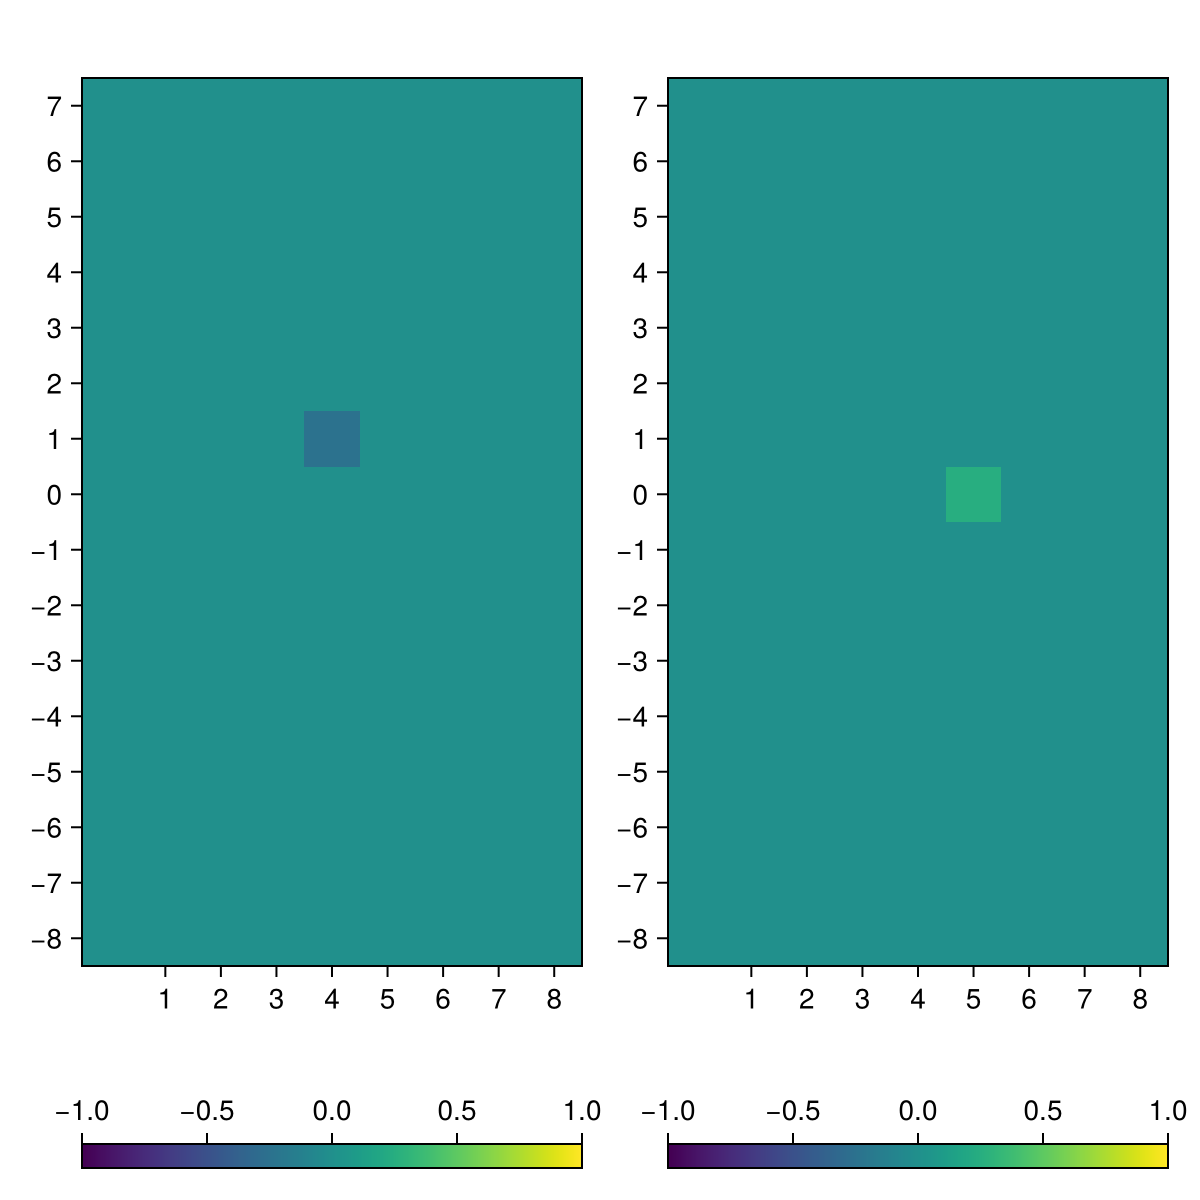

In [6]:
test_grid = TwoDGrid(nx=16, Lx=2π, T=Float32)
ψh = zeros(Complex{Float32}, test_grid.nkr, test_grid.nl)
ψ = zeros(Float32, test_grid.nx, test_grid.ny)
ψ .+= cos.( 4*test_grid.x .+  1*test_grid.y')
#ψ .+= cos.( 5*test_grid.x .+ -3*test_grid.y')
ψ .+= sin.( 5*test_grid.x .+  0*test_grid.y' .+ 0π/2)
mul!(ψh, test_grid.rfftplan, ψ)
ψh /= grid.nx
f = Figure(size=(600, 600))
ax1 = Axis(f[1, 1]; xticks=1:grid.nkr, yticks=-grid.nl:(grid.nl-1), aspect=DataAspect())
cf1 = heatmap!(ax1, Array(test_grid.kr)[:], fftshift(Array(test_grid.l)[:]), fftshift(real.(Array(ψh)), 2), colorrange=(-1, 1))
Colorbar(f[2, 1], cf1, vertical=false)
ax2 = Axis(f[1, 2]; xticks=1:grid.nkr, yticks=-grid.nl:(grid.nl-1), aspect=DataAspect())
cf2 = heatmap!(ax2, Array(test_grid.kr)[:], fftshift(Array(test_grid.l)[:]), fftshift(imag.(Array(ψh)), 2), colorrange=(-1, 1))
Colorbar(f[2, 2], cf2, vertical=false)
#heatmap(ψ)
f

In [126]:
function abcdef(x::AbstractArray{T, 3}) where {T}
    return x[1,1,1]
end

A = [1; 1;; 1; 1;;; 1; 1;; 1; 1;;;]
abcdef(A)

1

In [74]:
vars = prob.vars
clock = prob.clock


0.0006393192294700216

In [81]:
maximum(vars.η)

0.0004136587764574625

In [80]:
1e-3

0.001